In [25]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools
import random

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.layers import Dense
from keras._tf_keras.keras.models import Sequential

from keras._tf_keras.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras._tf_keras.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from keras._tf_keras.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras._tf_keras.keras.applications.inception_v3 import InceptionV3
from keras._tf_keras.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras._tf_keras.keras.applications.efficientnet import EfficientNetB0
# from keras._tf_keras.keras.utils import multi_gpu_model

from keras._tf_keras.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
# import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

2.16.1


In [6]:
is_train = True

model_name = 'u-net'
assert model_name in ['ed_model', 'u-net']

In [7]:
TRAIN_BASE_DIR='C:/Workspace/Dog/dataset/train/label/결막염'
paths = ['무', '유']

In [8]:
train_filenames = []

for path in paths:
    full_path = os.path.join(TRAIN_BASE_DIR, path)
    train_filenames += [os.path.join(full_path, f) for f in os.listdir(full_path)]

In [9]:
print(len(train_filenames))

38396


In [10]:
y_train_filenames = [filename for filename in train_filenames if filename.endswith('.json')]
x_train_filenames = [filename for filename in train_filenames if filename.endswith(('.png', '.jpg', '.jpeg'))]

In [11]:
print(len(x_train_filenames), len(y_train_filenames))

19198 19198


valid

In [12]:
valid_BASE_DIR='C:/Workspace/Dog/dataset/valid/label/결막염'
paths = ['무', '유']

In [13]:
valid_filenames = []

for path in paths:
    full_path = os.path.join(valid_BASE_DIR, path)
    valid_filenames += [os.path.join(full_path, f) for f in os.listdir(full_path)]

In [14]:
print(len(valid_filenames))

4806


In [15]:
y_valid_filenames = [filename for filename in valid_filenames if filename.endswith('.json')]
x_valid_filenames = [filename for filename in valid_filenames if filename.endswith(('.png', '.jpg', '.jpeg'))]

In [16]:
print(len(x_valid_filenames), len(y_valid_filenames))

2403 2403


examples

In [17]:
num_train_examples = len(x_train_filenames)
num_valid_examples = len(x_valid_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_valid_examples))

Number of training examples: 19198
Number of test examples: 2403


함수

In [18]:
import json

# JSON 파일에서 정보를 가져오는 함수
def get_label_info_from_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        return data['label']

In [19]:
def get_images_info_from_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        return data['images']

# visualize

Bounding Box (x, y, width, height): 0.0 0 3264 2448
[3264, 2448]
Bounding Box (x, y, width, height): 1672.16 1099 1789 2193
[3024, 4032]
Bounding Box (x, y, width, height): 1011.03 1486 2246 2106
[3387, 2541]
Bounding Box (x, y, width, height): 0.0 0 3264 2448
[3264, 2448]
Bounding Box (x, y, width, height): 1533.34 1930 2283 1965
[4032, 3024]


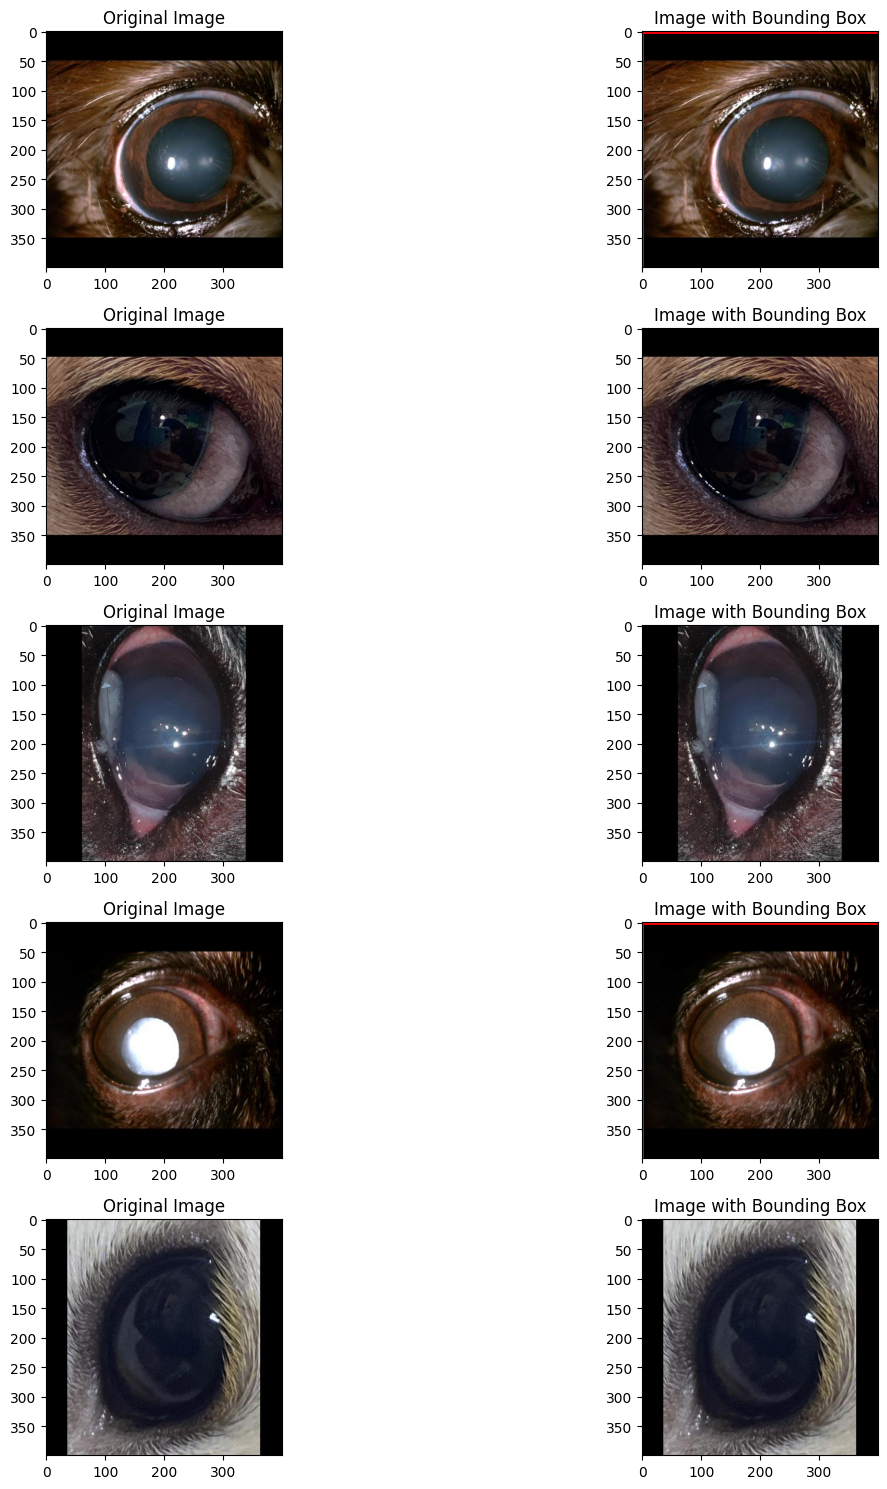

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(15, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    info = get_label_info_from_json(y_pathname)['label_bbox']

    # bbox 생성 및 좌표 라운딩
    bbox_x, bbox_y, bbox_width, bbox_height = info
    bbox_x = (bbox_x)
    bbox_y = int(round(bbox_y))
    bbox_width = int(round(bbox_width))
    bbox_height = int(round(bbox_height))

    print("Bounding Box (x, y, width, height):", bbox_x, bbox_y, bbox_width, bbox_height)
    print(get_images_info_from_json(y_pathname)['meta']['width_height'])

    # 오른쪽에 새로운 subplot 만들기
    plt.subplot(display_num, 2, i + 2)

    # 원본 이미지를 표시
    original_image = Image.open(x_pathname)
    plt.imshow(original_image)

    # bbox를 그림에 추가
    bbox = patches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(bbox)

    plt.title("Image with Bounding Box")

# 그림 출력
plt.tight_layout()
plt.show()


Bounding Box (x, y, width, height): 1358.7 2091 2989 2184
[4896, 3672]
유
유
유
Bounding Box (x, y, width, height): 0.0 0 3264 2448
[3264, 2448]
무
유
유
Bounding Box (x, y, width, height): 0.0 0 1920 1280
[1920, 1280]
무
유
유
Bounding Box (x, y, width, height): 0.0 0 3264 2448
[3264, 2448]
무
유
유
Bounding Box (x, y, width, height): 0.0 0 2304 1728
[2304, 1728]
유
유
유


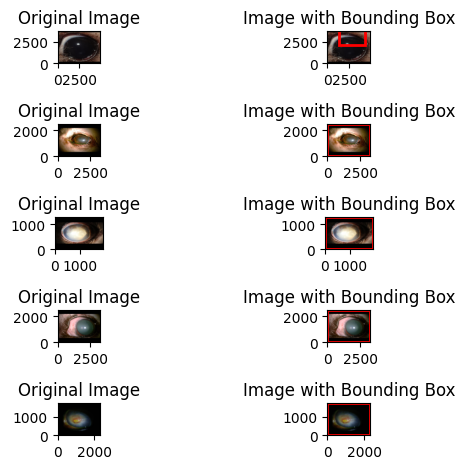

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure()
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    image_width = get_images_info_from_json(y_pathname)['meta']['width_height'][0]
    image_height = get_images_info_from_json(y_pathname)['meta']['width_height'][1]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname), extent=[0, image_width, 0, image_height])
    plt.title("Original Image")

    info = get_label_info_from_json(y_pathname)['label_bbox']

    # bbox 생성 및 좌표 라운딩
    bbox_x, bbox_y, bbox_width, bbox_height = info
    bbox_x = (bbox_x)
    bbox_y = int(round(bbox_y))
    bbox_width = int(round(bbox_width))
    bbox_height = int(round(bbox_height))

    # print(info)

    print("Bounding Box (x, y, width, height):", bbox_x, bbox_y, bbox_width, bbox_height)
    print(get_images_info_from_json(y_pathname)['meta']['width_height'])

    # 오른쪽에 새로운 subplot 만들기
    plt.subplot(display_num, 2, i + 2)

    # 원본 이미지를 표시
    original_image = Image.open(x_pathname)
    plt.imshow(Image.open(x_pathname), extent=[0, image_width, 0, image_height])

    print(get_label_info_from_json(y_pathname)['label_disease_lv_1'])
    print(get_label_info_from_json(y_pathname)['label_disease_lv_2'])
    print(get_label_info_from_json(y_pathname)['label_disease_lv_3'])

    # bbox를 그림에 추가
    bbox = patches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(bbox)

    plt.title("Image with Bounding Box")

# 그림 출력
plt.tight_layout()
plt.show()


In [22]:
def onehot_encode_label(label):
    if label == '무':
        return 0
    else:
        return 1

In [23]:
def get_label_info_from_json(json_filename):
    # 여기에서는 더미 데이터를 반환하는 것으로 가정합니다.
    label_bbox = get_label_info_from_json(y_pathname)['label_bbox']  # 예시 박스 위치: [x_min, y_min, x_max, y_max]
    
    # 병 심각도가 '무'인 경우를 0, '유'인 경우를 1로 변환
    label_disease_lv_1 = get_label_info_from_json(y_pathname)['label_disease_lv_1']
    # label_disease_lv_2 = onehot_encode_label(get_label_info_from_json(y_pathname)['label_disease_lv_2'])
    # label_disease_lv_3 = onehot_encode_label(get_label_info_from_json(y_pathname)['label_disease_lv_3'])
    
    return {'label_bbox': label_bbox, 'label_disease_lv_1': label_disease_lv_1, 'label_disease_lv_2': label_disease_lv_2, 'label_disease_lv_3': label_disease_lv_3}

In [24]:
val_path = 'C:/Workspace/Dog/dataset/valid'

seed = 2

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

class Import_data:
    def __init__(self, train_path):
        self.train_path = train_path
        self.test_path = val_path

    def train(self):
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           featurewise_std_normalization=True,
                                           zoom_range=0.2,
                                           channel_shift_range=0.1,
                                           rotation_range=20,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True
                                           )
        train_generator = train_datagen.flow_from_directory(
            self.train_path,
            target_size=(224, 224),
            batch_size=8
        )
        val_generator = train_datagen.flow_from_directory(
            self.test_path,
            target_size=(224, 224),
            batch_size=8
        )

        return train_generator, val_generator

In [26]:
def densenet_121():
    network = DenseNet121(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                          pooling='avg')
    return network


class Load_model:
    def __init__(self, train_path, model_name):
        self.num_class = len(os.listdir(train_path))
        self.model_name = model_name

    def resnet_v1_50(self):
        network = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                           pooling='avg')
        return network

    def resnet_v1_101(self):
        network = ResNet101(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                            pooling='avg')
        return network

    def resnet_v1_152(self):
        network = ResNet152(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                            pooling='avg')
        return network

    def resnet_v2_50(self):
        network = ResNet50V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                             pooling='avg')
        return network

    def resnet_v2_101(self):
        network = ResNet101V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                              pooling='avg')
        return network

    def resnet_v2_152(self):
        network = ResNet152V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                              pooling='avg')
        return network

    def densenet_169(self):
        network = DenseNet169(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                              pooling='avg')
        return network

    def densenet_201(self):
        network = DenseNet201(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                              pooling='avg')
        return network

    def inception_v3(self):
        network = InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                              pooling='avg')
        return network

    def inception_v4(self):
        network = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                                    pooling='avg')
        return network

    def efficientnet(self):
        network = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
                                 pooling='avg')
        return network


    def build_network(self):
        if self.model_name == 'resnet_v1_50':
            network = self.resnet_v1_50()
        elif self.model_name == 'resnet_v1_101':
            network = self.resnet_v1_101()
        elif self.model_name == 'resnet_v1_152':
            network = self.resnet_v1_152()
        elif self.model_name == 'resnet_v2_50':
            network = self.resnet_v2_50()
        elif self.model_name == 'resnet_v2_101':
            network = self.resnet_v2_101()
        elif self.model_name == 'resnet_v2_152':
            network = self.resnet_v2_152()
        elif self.model_name == 'densenet_121':
            network = densenet_121()
        elif self.model_name == 'densenet_169':
            network = self.densenet_169()
        elif self.model_name == 'densenet_201':
            network = self.densenet_201()
        elif self.model_name == 'inception_v3':
            network = self.inception_v3()
        elif self.model_name == 'inception_v4':
            network = self.inception_v4()
        elif self.model_name == 'efficientnet':
            network = self.efficientnet()

        model = Sequential()
        model.add(network)
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(self.num_class, activation='softmax'))
        model.summary()

        return model


In [30]:
class Fine_tunning:
    def __init__(self, train_path, model_name, epoch):
        self.data = Import_data(train_path)
        self.train_data, self.val_data = self.data.train()
        self.load_model = Load_model(train_path, model_name)
        self.epoch = epoch
        self.model_name = model_name
        self.train_path = train_path

    def training(self):
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-5, momentum=0.999, nesterov=True)
        model = self.load_model.build_network()
        save_folder = "C:/Workspace/Dog/model/"
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        check_point = ModelCheckpoint(save_folder + 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1,
                                      monitor='val_acc', save_best_only=True, mode='auto')
        
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['acc'])
        history = model.fit(
            self.train_data,
            epochs=self.epoch,
            validation_data=self.val_data,
            callbacks=[check_point],
            verbose=1
        )
        return history

    def save_accuracy(self, history):
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        epoch_list = list(epochs)

        df = pd.DataFrame({'epoch': epoch_list, 'train_accuracy': acc, 'validation_accuracy': val_acc},
                          columns=['epoch', 'train_accuracy', 'validation_accuracy'])
        df_save_path = save_folder + 'accuracy.csv'
        df.to_csv(df_save_path, index=False, encoding='euc-kr')

        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        save_path = save_folder + 'accuracy.png'
        plt.savefig(save_path)
        plt.cla()

        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        save_path = save_folder + 'loss.png'
        plt.savefig(save_path)
        plt.cla()

        name_list = os.listdir(save_folder)
        h5_list = []
        for name in name_list:
            if '.h5' in name:
                h5_list.append(name)
        h5_list.sort()
        h5_list = [save_folder + name for name in h5_list]
        for path in h5_list[:len(h5_list) - 1]:
            os.remove(path)
        K.clear_session()


In [ ]:
train_path = 'dataset/train/label/결막염' #경로 마지막에 반드시 '/'를 기입해야합니다.
model_name = 'resnet_v1_50'
epoch = 1

if __name__ == '__main__':
    fine_tunning = Fine_tunning(train_path=train_path,
                                model_name=model_name,
                                epoch=epoch)
    history = fine_tunning.training()
    fine_tunning.save_accuracy(history)

In [ ]:
import pandas as pd
from sklearn import metrics

from keras._tf_keras.keras.models import load_model
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

# modelPath = './model_saved/train/efficientnet_200/'  # 모델이 저장된 경로
modelPath = '/home/mark11/Dog/model_saved/train/resnet_v1_50_100/'  # 모델이 저장된 경로
weight = 'model-066-0.874390-0.860614.h5'        # 학습된 모델의 파일이름
test_Path = '/home/mark11/label/cat/Sequestrum/test/' # 테스트 이미지 폴더

model = load_model(modelPath + weight)
datagen_test = ImageDataGenerator(rescale=1./255)
generator_test = datagen_test.flow_from_directory(directory=test_Path,
                                                  target_size=(224, 224),
                                                  batch_size=256,
                                                  shuffle=False)

# model로 test set 추론
generator_test.reset()
cls_test = generator_test.classes
cls_pred = model.predict_generator(generator_test, verbose=1, workers=0)
cls_pred_argmax = cls_pred.argmax(axis=1)

# 결과 산출 및 저장
report = metrics.classification_report(y_true=cls_test, y_pred=cls_pred_argmax, output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv(f'./output/report_test_{weight[:-3]}.csv', index=True, encoding='cp949')
print(report)